In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df = pd.read_excel("Q1_Restaurant_Data.xlsx")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (3650, 5)


,Day,Stock Units,Sold Units,Stock Change,May missed demand?
0,1,100,100,5,Yes
1,2,105,105,4,Yes
2,3,109,109,3,Yes
3,4,112,85,-5,No
4,5,107,107,3,Yes


In [38]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_'))
df.columns.tolist()

['day', 'stock_units', 'sold_units', 'stock_change', 'may_missed_demand?']

In [11]:
numeric_cols = ['stock_units', 'sold_units']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Check missing values
df.isnull().sum()

day                   0
stock_units           0
sold_units            0
stock_change          0
may_missed_demand?    0
dtype: int64

In [20]:
df[['stock_units', 'sold_units']] = (
    df[['stock_units', 'sold_units']].clip(lower=0))

In [21]:
df['sold_units'] = np.minimum(df['sold_units'], df['stock_units'])

In [22]:
df['missed_demand_flag'] = df['sold_units'] >= df['stock_units']
df['missed_demand_flag'].value_counts(normalize=True)

missed_demand_flag
True     0.5
False    0.5
Name: proportion, dtype: float64

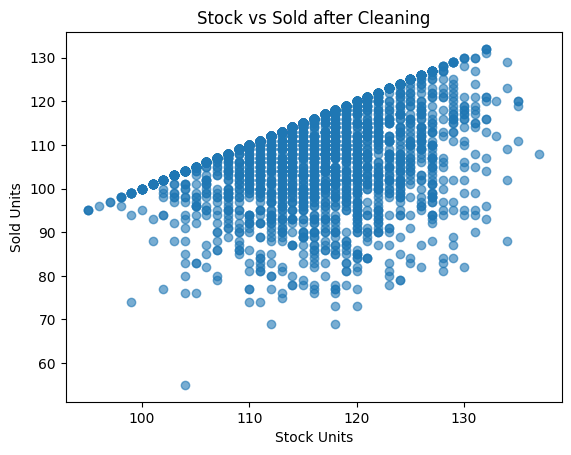

In [23]:
df[['stock_units', 'sold_units']].describe()
plt.scatter(df['stock_units'], df['sold_units'], alpha=0.6)
plt.xlabel("Stock Units")
plt.ylabel("Sold Units")
plt.title("Stock vs Sold after Cleaning")
plt.show()

# CÂU 1.1: ƯỚC ĐOÁN NHU CẦU TRUNG BÌNH HÀNG NGÀY

In [ ]:
# Ước lượng nhu cầu từ ngày không censor

observed_demand = df.loc[~df['missed_demand_flag'], 'sold_units']
mean_demand = observed_demand.mean()
median_demand = observed_demand.median()
std_demand = observed_demand.std()
mean_demand, median_demand, std_demand

(np.float64(104.18246575342465),
 np.float64(105.0),
 np.float64(10.04633560300997))

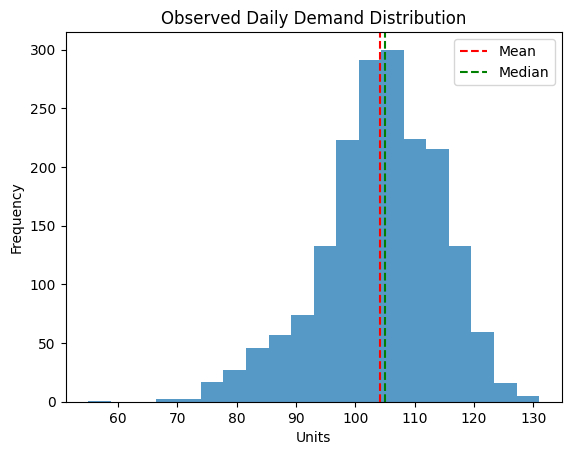

In [ ]:
# Kiểm tra phân phối nhu cầu

plt.hist(observed_demand, bins=20, alpha=0.75)
plt.axvline(mean_demand, color='red', linestyle='--', label='Mean')
plt.axvline(median_demand, color='green', linestyle='--', label='Median')
plt.legend()
plt.title("Observed Daily Demand Distribution")
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.show()


# CÂU 1.2.1: ĐÁNH GIÁ CHIẾN LƯỢC NHẬP HÀNG HIỆN TẠI

In [ ]:
# Lợi nhuận

df['profit_current'] = 3 * df['sold_units'] - df['stock_units']
df['profit_current'].mean()

np.float64(210.8772602739726)

In [28]:
# So sánh lợi nhuận theo trạng thái thiếu hàng

df.groupby('missed_demand_flag')['profit_current'].mean()

missed_demand_flag
False    195.024658
True     226.729863
Name: profit_current, dtype: float64

# CÂU 1.2.2: CHIẾN LƯỢC TỐI ƯU – NEWSVENDOR

In [29]:
# Xác định critical ratio

understock_cost = 2
overstock_cost = 1

critical_ratio = understock_cost / (understock_cost + overstock_cost)
critical_ratio


0.6666666666666666

In [30]:
# Lượng nhập tối ưu

optimal_stock = np.quantile(observed_demand, critical_ratio)
optimal_stock

np.float64(109.0)

In [34]:
# Mô phỏng lợi nhuận chiến lược tối ưu

df['optimal_stock'] = optimal_stock
df['optimal_sold'] = np.minimum(df['sold_units'], optimal_stock)
df['profit_optimal'] = 3 * df['optimal_sold'] - df['optimal_stock']
df[['profit_current', 'profit_optimal']].mean()

profit_current    210.877260
profit_optimal    206.747123
dtype: float64

In [35]:
df['profit_optimal'].mean() - df['profit_current'].mean()

np.float64(-4.13013698630138)